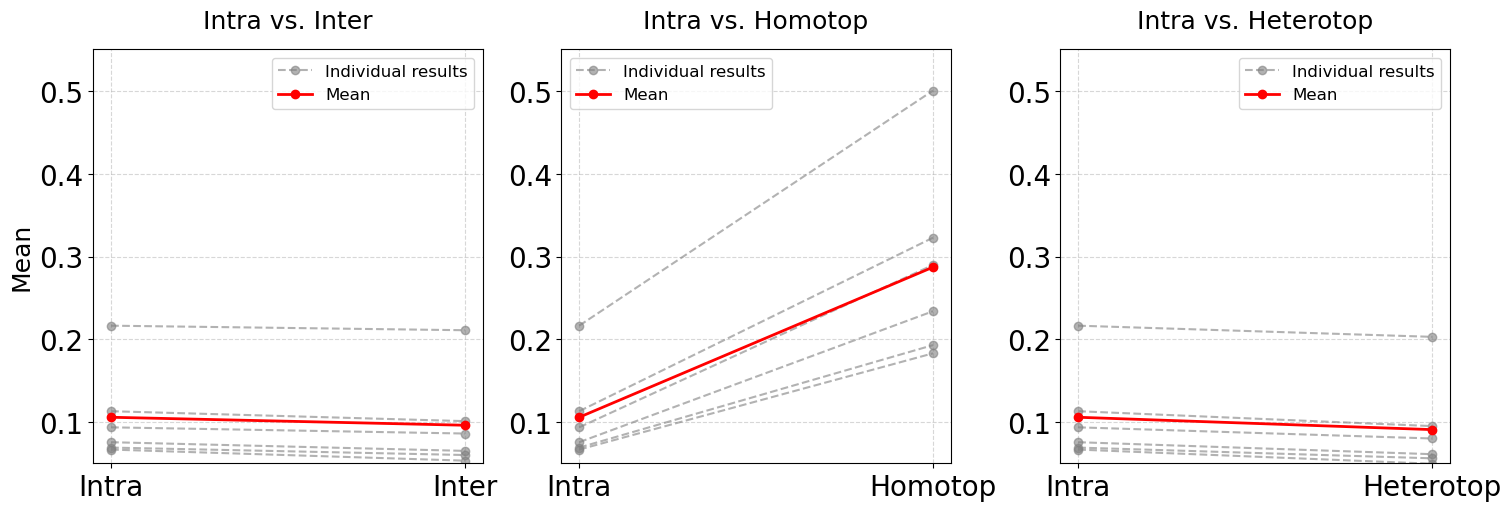

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the monkeys 
# Each line different monkey
# Each column different connection type
# --> From left to right: Intrahemispheric, Interhemispheric, Homotopic, Heterotopic
data = np.array([
    [0.0755, 0.065, 0.234, 0.061],  
    [0.0935, 0.086, 0.290, 0.080],
    [0.113, 0.101, 0.323, 0.095],
    [0.069, 0.060, 0.193, 0.056],
    [0.2165, 0.211, 0.501, 0.203],
    [0.066579, 0.053165, 0.183058, 0.049454]
])

# Condition pairs for the three comparisons
comparisons = [("Intra", "Inter", 0, 1), 
               ("Intra", "Homotop", 0, 2), 
               ("Intra", "Heterotop", 0, 3)]

# Generate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

for idx, (ax, (cond1, cond2, i, j)) in enumerate(zip(axes, comparisons)):
    # Calculate the means
    mean1, mean2 = np.mean(data[:, i]), np.mean(data[:, j])
    
    # Line for each monkey in gray
    for person in range(data.shape[0]):
        ax.plot([cond1, cond2], [data[person, i], data[person, j]], 
                marker="o", linestyle="dashed", alpha=0.6, color="gray", label="Individual results" if person == 0 else "")

    # Means in a thick line (red)
    ax.plot([cond1, cond2], [mean1, mean2], marker="o", linestyle="-", 
            color="red", linewidth=2, label=f"Mean")

   # Calculate the Global minimum and maximum
    global_min = 0.05  
    global_max = np.max(data) * 1.1  
    
    # Consistent y-axis scale
    ax.set_ylim(global_min, global_max)

    # Axis titles and legend
    ax.set_title(f"{cond1} vs. {cond2}", fontsize=18, pad=15)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize=12)
    
    # X-Axis label only ones
    if idx == 0:
        ax.set_ylabel("Mean", fontsize=18)
    else:
        ax.set_ylabel("")

plt.savefig("Comparison_conditions_0605.png", dpi=300)
plt.show()


In [4]:
import pandas as pd
import os
from scipy.stats import friedmanchisquare, wilcoxon 
import numpy as np 

# Subjects and prefixes
subjects = ['Linus', 'Curius', 'Linus1015', 'Pinocchio', 'Rio', 'Norman']
prefix_numbers = ['002']

# Collecting data
data = []

for subject in subjects:
    for prefix_number in prefix_numbers:
        file_path = f'netts/csv_files/long_correlation_matrix_{subject}_predrug_{prefix_number}.csv'

        if not os.path.exists(file_path):
            print(f"File not found: {file_path} — will be skipped.")
            continue

        df = pd.read_csv(file_path)
        entry = {'subject': subject}

        def safe_mean(label, df_filtered):
            if df_filtered.empty:
                print(f" Caution: No data for {subject} – {label}")
                return float('nan')
            mean_val = df_filtered['Correlation'].mean()
            if pd.isna(mean_val):
                print(f"Caution: Mean is NaN for {subject} – {label}")
            elif len(df_filtered) < 3:
                print(f" Attention: Only {len(df_filtered)} values for {subject} – {label}")
            return mean_val

        # Intra: CL-CL und CR-CR
        df_intra_L = df[
            df['Variable1'].str.startswith('CL_') &
            df['Variable2'].str.startswith('CL_') &
            (df['Variable1'] != df['Variable2']) &
            (df['Correlation'] != 1)
        ]
        df_intra_R = df[
            df['Variable1'].str.startswith('CR_') &
            df['Variable2'].str.startswith('CR_') &
            (df['Variable1'] != df['Variable2']) &
            (df['Correlation'] != 1)
        ]
        entry['intra'] = safe_mean("intra (CL↔CL & CR↔CR)", pd.concat([df_intra_L, df_intra_R]))

        # Inter: CL-CR + CR-CL
        df_inter_L = df[
            df['Variable1'].str.startswith('CL_') &
            df['Variable2'].str.startswith('CR_') &
            (df['Correlation'] != 1)
        ]
        df_inter_R = df[
            df['Variable1'].str.startswith('CR_') &
            df['Variable2'].str.startswith('CL_') &
            (df['Correlation'] != 1)
        ]
        entry['inter'] = safe_mean("inter (CL↔CR + CR↔CL)", pd.concat([df_inter_L, df_inter_R]))

        # Homotopic: Same ending (e.g., CL_V1 vs CR_V1)
        df_homotopic = df[
            df['Variable1'].str.startswith('CL_') &
            df['Variable2'].str.startswith('CR_') &
            (df['Variable1'].str[3:] == df['Variable2'].str[3:]) &  
            (df['Correlation'] != 1)
        ]
        entry['homotopic'] = safe_mean("homotopic (gleiche Region)", df_homotopic)

        # Heterotopic: different ending
        df_heterotopic = df[
            df['Variable1'].str.startswith('CL_') &
            df['Variable2'].str.startswith('CR_') &
            (df['Variable1'].str[3:] != df['Variable2'].str[3:]) &
            (df['Correlation'] != 1)
        ]
        entry['heterotopic'] = safe_mean("heterotopic (unterschiedliche Region)", df_heterotopic)

        data.append(entry)

# Convert into dataframe
df_corr = pd.DataFrame(data)
print("\n=== Means per Subject ===")
print(df_corr)

# Drop NaNs for the relevant columns
df_corr_clean = df_corr.dropna(subset=['intra', 'inter', 'homotopic', 'heterotopic'])
if df_corr_clean.shape[0] < len(subjects):
    print(f"\n  {len(subjects) - df_corr_clean.shape[0]} Subjects were excluded due to missing values.")


### Statistical tests

if df_corr_clean.shape[0] >= 3:
    print("\n=== Friedman-Test: intra vs inter vs homotopic vs heterotopic ===")
    stat, p = friedmanchisquare(
        df_corr_clean['intra'],
        df_corr_clean['inter'],
        df_corr_clean['homotopic'],
        df_corr_clean['heterotopic']
    )
    print(f"Test statistic = {stat:.4f}, p-Wert = {p:.4f}")

    # Wilcoxon rank-sum test
    print("\n=== Wilcoxon rank-sum tests: pairwise comparisons")

    def run_wilcoxon_test_styled(label, col1_series, col2_series):
        col1_values = col1_series.to_numpy()
        col2_values = col2_series.to_numpy()

        # Überprüfen, ob genügend Daten vorhanden sind, bevor der Test durchgeführt wird
        if len(col1_values) > 1 and len(col2_values) > 1:
            stat, p = wilcoxon(col1_values, col2_values, zero_method='wilcox', correction=True)
            print(f"{label}: Test statistic (W) = {stat:.4f}, P-Wert = {p:.4f}")
        else:
            print(f"{label}: Too little data for the Wilcoxon test (requires at least 2 valid pairs).")

    # Intra vs Inter
    run_wilcoxon_test_styled("Intra vs Inter", df_corr_clean['intra'], df_corr_clean['inter'])

    # Intra vs Homotopic
    run_wilcoxon_test_styled("Intra vs Homotopic", df_corr_clean['intra'], df_corr_clean['homotopic'])

    # Intra vs Heterotopic
    run_wilcoxon_test_styled("Intra vs Heterotopic", df_corr_clean['intra'], df_corr_clean['heterotopic'])

else:
    print("\n Too few valid subjects for the Friedman test (at least 3 subjects with complete data are required).")
    print("The Wilcoxon tests are also not performed because the minimum requirement for the Friedman test is not met.")


=== Means per Subject ===
     subject     intra     inter  homotopic  heterotopic
0      Linus  0.093629  0.086006   0.289896     0.080180
1     Curius  0.075750  0.065389   0.234346     0.060562
2  Linus1015  0.112962  0.101175   0.323335     0.094827
3  Pinocchio  0.067119  0.058319   0.192706     0.054586
4        Rio  0.216235  0.211315   0.501148     0.203034
5     Norman  0.066579  0.053165   0.183058     0.049454

=== Friedman-Test: intra vs inter vs homotopic vs heterotopic ===
Test statistic = 18.0000, p-Wert = 0.0004

=== Wilcoxon rank-sum tests: pairwise comparisons
Intra vs Inter: Test statistic (W) = 0.0000, P-Wert = 0.0312
Intra vs Homotopic: Test statistic (W) = 0.0000, P-Wert = 0.0312
Intra vs Heterotopic: Test statistic (W) = 0.0000, P-Wert = 0.0312


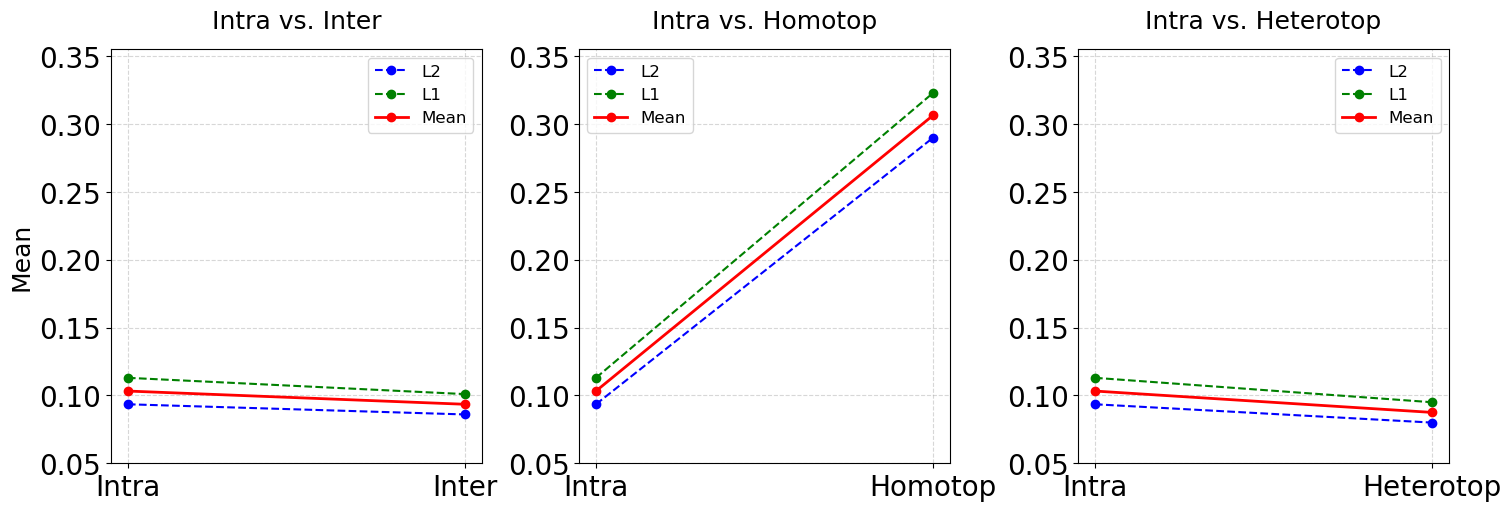

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Data from the monkeys 
# Each line different monkey
# Each column different connection type
# --> From left to right: Intrahemispheric, Interhemispheric, Homotopic, Heterotopic
data = np.array([ 
    [0.0935, 0.086, 0.290, 0.080],#L2
    [0.113, 0.101, 0.323, 0.095]#L1
])
# Monkey Labels
primate = [
    "L2", "L1"
]
# Condition pairs for the three comparisons
comparisons = [("Intra", "Inter", 0, 1), 
               ("Intra", "Homotop", 0, 2), 
               ("Intra", "Heterotop", 0, 3)]

# Generate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
colors = ['blue', 'green']

for idx, (ax, (cond1, cond2, i, j)) in enumerate(zip(axes, comparisons)):
    # Calculate the means
    mean1, mean2 = np.mean(data[:, i]), np.mean(data[:, j])
    
    # Setting color and label
    for k in range(len(primate)):
        ax.plot([0, 1], [data[k, i], data[k, j]],
                marker='o', linestyle='--', color=colors[k],
                label=primate[k])

    # Means as a thick line
    ax.plot([cond1, cond2], [mean1, mean2], marker="o", linestyle="-", 
            color="red", linewidth=2, label=f"Mean")

   # Calculate the Global minimum and maximum
    global_min = 0.05 
    global_max = np.max(data) * 1.1
    
    # Consistent y-axis scale
    ax.set_ylim(global_min, global_max)

    # Axis titles and legend
    ax.set_title(f"{cond1} vs. {cond2}", fontsize=18, pad=15)
    ax.tick_params(axis='both', labelsize=20)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(fontsize=12)
    
    # X-Axis label only ones
    if idx == 0:
        ax.set_ylabel("Mean", fontsize=18)
    else:
        ax.set_ylabel("")

plt.savefig("L_Li_Comparison_conditions_1106.png", dpi=300)
plt.show()
